<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/L05_Power_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Flow Simulations
In this lecture we will solve a power flow using Gauss-Seidel iterations. 
![](https://raw.githubusercontent.com/supsi-dacd-isaac/teaching/main/2021SmartGrids/figs/power_flow.png)
Let's assume to know the impedences in each line 

Z0 = .05 + j.1 

Z1 = .05 + j.05 

Z2 = .15 + j.2 

Z3 = .04 + j.12

and that the buses 1 and 2 are generators with the possibility of modulating their reacitve power. We consider the module of their voltages constant and equal to:

V1 = 1.05 p.u.
V2 = 1.00 p.u.

and their active powers:
P1,P2 = 1 p.u.

We assume that there are loads in buses 3 and 4. Let's consider to know their active and reactive powers:

P3 = -0.9 p.u. , Q3 = 0 p.u.

P4 = -1 p.u. , Q4 = -0.2 p.u.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Let's define the grid parameters in terms of the m line impedances, and plot them as complex vectors.

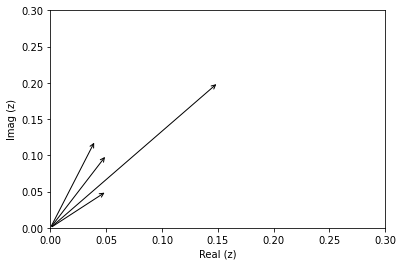

In [2]:
z =np.array([.05 + .1j, 
             .05 + .05j, 
             .15 + .2j, 
             .04 + .12j])

fig, ax = plt.subplots(1, 1)
[ax.annotate('', xy=(x.real, x.imag), xytext=(0, 0), arrowprops=dict(arrowstyle="->")) for i, x in enumerate(z)]
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.xlabel('Real (z)')
plt.ylabel('Imag (z)');

The second element we need to characterize our grid is the incidence matrix I, having n rows and m columns, where n is the number of nodes in the grid and m the number of branches. The incidence matrix is an alternative to the adiacence matrix to describe the topology of the grid. We can plot the resulting connections using networkx.

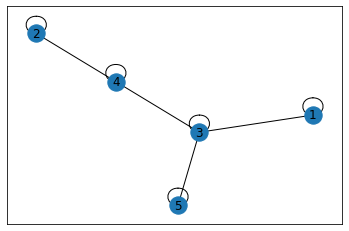

In [3]:
# ----------------------------------------------------------------------------
# EX1: define the incidence matrix
# ----------------------------------------------------------------------------
I_vect = [[1,  0,  0,  0],
    [0,  0,  0,  1],
   [-1,  1, -1,  0],
   [0,  0,  1, -1],
   [0, -1,  0,  0]] # define here the incidence matrix 
incidence = np.asanyarray(I_vect, dtype=int)

incidence_abs = np.abs(incidence)
adiacency = incidence_abs @ incidence_abs.T
graph = nx.from_numpy_matrix(adiacency)
graph = nx.relabel_nodes(graph, lambda x: x+1)

positions = nx.kamada_kawai_layout(graph)
nx.draw_networkx(graph, pos=positions)

In [4]:
# let's define vectors of known voltages magnitudes and angles 
VNM = np.array([1.05, 1, 0, 0, 1], dtype=bool).reshape(-1, 1)
VNA = np.array([0, 0, 0, 0, 0], dtype=bool).reshape(-1, 1)

# let's create boolean vectors indicating which voltage magnitudes and angles 
# are to use in the error checking phase of the iterations 
KNM = np.array([1, 1, 0, 0, 1], dtype=bool).reshape(-1, 1)
KNA = np.array([0, 0, 0, 0, 1], dtype=bool).reshape(-1, 1)

# let's define known active and reactive powers, and put 0 if they're not known
P = np.array([1, 1, -.9, -1, 0]).reshape(-1, 1)
Q = np.array([0, 0, 0, -.2, 0]).reshape(-1, 1)

# let's create boolean vectors indicating which active and reactive powers 
# are to use in the error checking phase of the iterations 
PC = np.array([1, 1, 1, 1, 0]).reshape(-1, 1)
QC = np.array([0, 0, 1, 1, 0]).reshape(-1, 1)


# we then define KUM and KUA boolean vectors to indicate the unknown quantities
KUM = ~KNM
KUA = ~KNA



We can now define the admittance matrix from the line admittance matrix.

In [5]:
Y = np.diag(1/z)
YN = incidence @ Y @ incidence.T # <------- fill this
print(YN)

[[  4.  -8.j    0.  +0.j   -4.  +8.j    0.  +0.j    0.  +0.j ]
 [  0.  +0.j    2.5 -7.5j   0.  +0.j   -2.5 +7.5j   0.  +0.j ]
 [ -4.  +8.j    0.  +0.j   16.4-21.2j  -2.4 +3.2j -10. +10.j ]
 [  0.  +0.j   -2.5 +7.5j  -2.4 +3.2j   4.9-10.7j   0.  +0.j ]
 [  0.  +0.j    0.  +0.j  -10. +10.j    0.  +0.j   10. -10.j ]]


### Load flow solutions
In order to retrieve a good solution for the power flow, we must pick reasonable starting values for the nodal voltages and angles. Even if the algorithm that we're gonna use is guaranteed to converge, the final solution isn't guaranteed to be the correct one. Generally speaking, we can choose voltage values close to unity since we are solving the power flow in per unit, and we can choose small deviations for the voltage angles. 

In [6]:
# starting values for voltages' magnitudes and angles
VM = np.array([1.05, 1, .99, .99, 1]).reshape(-1, 1)
VA = np.array([.02, .01, .01, .02, 0]).reshape(-1, 1)

In the following code we define a function to solve the power flow. As a second exercise, try to complete the definitions at the end of this function, to compute the voltage drop on the lines, the line currents  and the total power dissipated by the lines.

In [7]:
def solve_lf(NI,YN,VM,VA,VNM,VNA,KNM,KNA,P,Q,PC,QC, tol=1e-6, do_plot=False):
  """
  Solve approximated load flow
  """

  # unknown variables vectors
  KUM = ~KNM
  KUA = ~KNA

  # error initialization
  Error = 1
  N = len(VNM)

  # current iteration voltage vectors, combining known and unknown values

  VMAG = VNM * KNM + VM * KUM
  VANG = VNA * KNA + VA * KUA

  # complex voltage
  V = VMAG * np.exp(1j * VANG);

  # counter initialization 
  r=1;
  Errors = []

  while Error>tol:

    for i in range(N): # iterate over all nodes
        # the solution method depends on the node type
        if (KUM[i] == 1) and (KUA[i] == 1): # if it's a load
            pvc= (P[i]-1j * Q[i]) / np.conj(V[i])
            for n in range(N):
                if n !=i: 
                    pvc = pvc - (YN[i,n] * V[n]) 
            V[i] = pvc/YN[i,i]
        elif (KUM[i] == 0) and (KUA[i] == 1): # if it's a generator
            Qn = np.imag(V[i] * np.conj(YN[[i],:] @ V))
            pvc= (P[i] - 1j * Qn) / np.conj(V[i])
            for n in range(N):
                if n !=i: 
                    pvc = pvc - (YN[i,n] * V[n])
            pv=pvc/YN[i,i]
            V[i] = VM[i] @ np.exp(1j * np.angle(pv))

    # recompute nodal currents 
    I = (YN@V)

    # recompute powers
    PI = np.real(V * np.conj(I));
    QI = np.imag(V * np.conj(I));

    # let's recompute current solutions' distances from known quantities
    PERR = (P-PI) * PC
    QERR = (Q-QI) * QC
    Error = np.sum(np.abs(PERR)**2 + np.abs(QERR)**2)
    Errors.append(Error)
    r=r+1
    if r%2==0 and do_plot:
      plt.figure()
      nx.set_node_attributes(graph, {k:v.real for k, v in zip(graph.nodes, np.abs(V).ravel())}, 'v')
      nx.draw_networkx(graph, node_color=list(nx.get_node_attributes(graph, 'v').values()), pos=positions)
  
  # ----------------------------------------------------------------------------
  # EX2: complete the code to compute the following quantities:
  # ----------------------------------------------------------------------------

  I = YN @ V 
  DVline = 0 
  Iline = 0 
  Sloss = 0 
  return V,P,Q,I,DVline,Iline,Sloss, Errors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


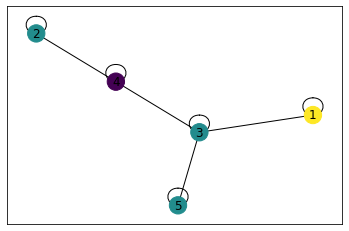

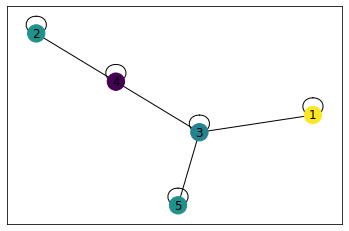

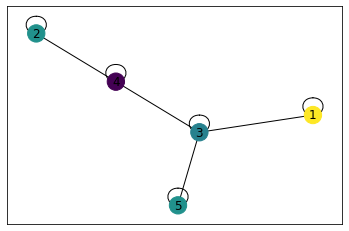

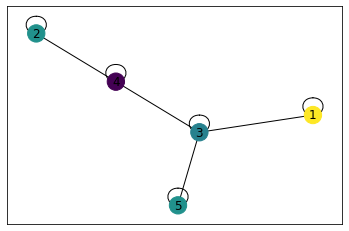

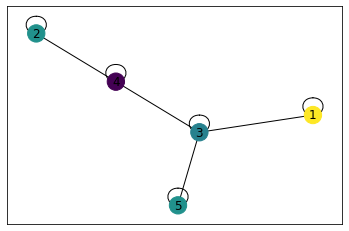

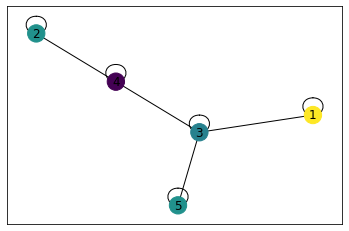

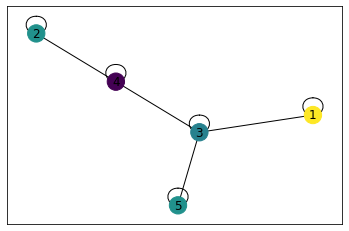

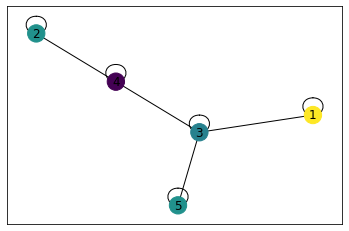

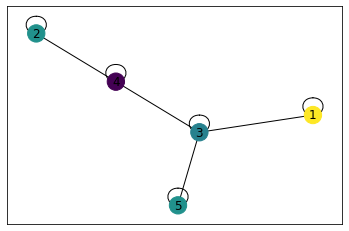

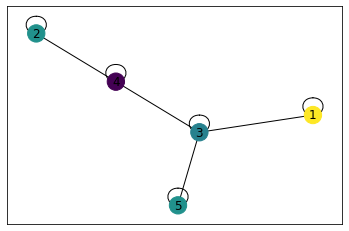

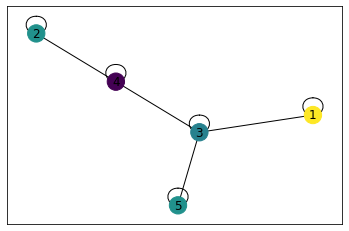

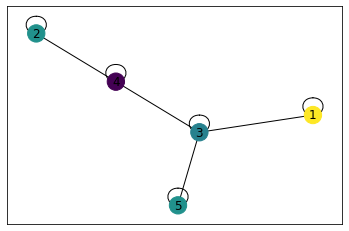

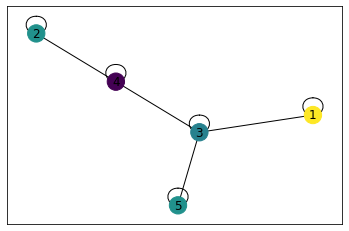

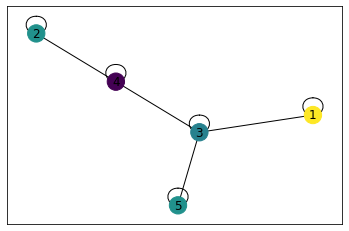

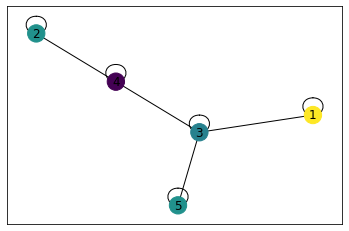

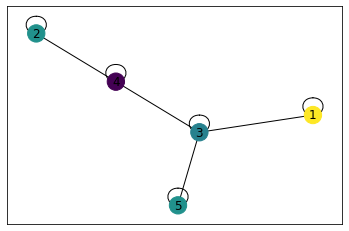

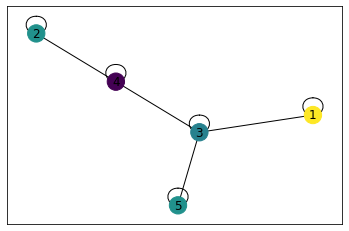

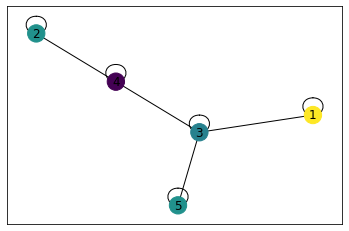

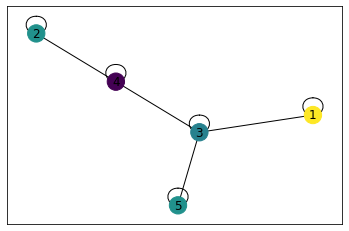

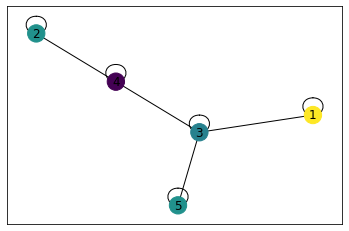

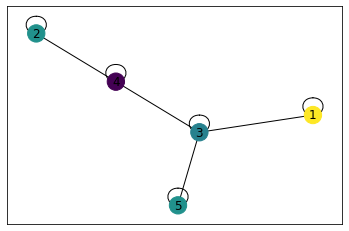

In [8]:
V,P,Q,I,DVline,Iline,Sloss, errs = solve_lf(incidence, YN,VM,VA,VNM,VNA,KNM,KNA,P,Q,PC,QC, tol=1e-12, do_plot=True)

Let's now assume that a PV power plant has been installed in the 4th node, injecting 2 kW of active power. We can re-solve the power flow and observe the change in the voltages' magnitudes. In order to counteract this voltage variation we can use the PV's inverter capacity to inject reactive power into the grid, by changing the power factor(PF). The PF is defined as the change in active over apparent power. Let's assume the starting PF is 1 and retrieve the initial active power.
$$PF = \frac{\vert P \vert}{\vert S \vert}=cos(\phi)$$
$$ \vert P \vert = \vert S \vert Re\{e^{i acos(\phi)} \}$$
$$ \vert Q \vert = \vert S \vert Im\{e^{i acos(\phi)} \}$$
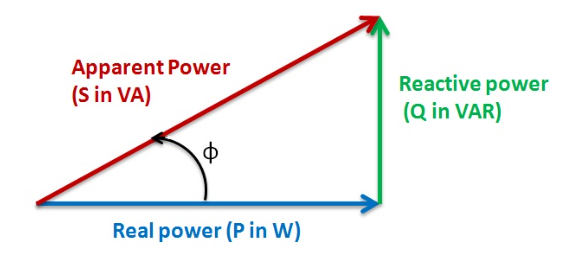

In [10]:
Ppv =  np.asanyarray([0, 0, 0, 2, 0 ]).reshape(-1, 1) # active power of PV power plant in the grid
Qpv =  np.asanyarray([0, 0, 0, 0, 0 ]).reshape(-1, 1) # reactive power of PV power plant in the grid
Pnew = P+Ppv
Qnew = Q+Qpv

V1,P1,Q1,I1,DVline1,Iline1,Sloss1, errs1 = solve_lf(incidence,YN,VM,VA,VNM,VNA,KNM,KNA,Pnew,Qnew,PC,QC)
print('Original voltage magnitudes: {}'.format(np.abs(V)))
print('Voltage magnitudes: {}'.format(np.abs(V1)))


Original voltage magnitudes: [[1.05      ]
 [1.        ]
 [0.99331513]
 [0.94941082]
 [1.        ]]
Voltage magnitudes: [[1.05      ]
 [1.        ]
 [0.98739994]
 [1.01150589]
 [1.        ]]


In [11]:
Smag0 = Ppv[3] # apparent power when PF=1 

# let's write two functions that reconstruct active and reactive power of the 
# inverter from the apparent power and the PF.

from_pf_to_p = lambda s,pf: np.real(s*np.exp(1j*np.arccos(pf)))
from_pf_to_q = lambda s,pf: np.imag(s*np.exp(1j*np.arccos(pf)))

P_inv = from_pf_to_p(Smag0,0.5);
Q_inv = from_pf_to_q(Smag0,0.5);

We can write a simple bisection algorithm to find the optimal PF value to bring back the voltage magnitude in the 4th node to the original condition in which no PV where installed.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Iteration 0, dist -1.424e-01, v_4_mag 0.807, pf 0.500
Iteration 1, dist -8.022e-02, v_4_mag 0.869, pf 0.750
Iteration 2, dist -3.696e-02, v_4_mag 0.912, pf 0.875
Iteration 3, dist -6.775e-03, v_4_mag 0.943, pf 0.938
Iteration 4, dist 1.414e-02, v_4_mag 0.964, pf 0.969
Iteration 5, dist 2.848e-03, v_4_mag 0.952, pf 0.953
Iteration 6, dist -2.125e-03, v_4_mag 0.947, pf 0.945
Iteration 7, dist 3.162e-04, v_4_mag 0.950, pf 0.949
Iteration 8, dist -9.153e-04, v_4_mag 0.948, pf 0.947
Iteration 9, dist -3.023e-04, v_4_mag 0.949, pf 0.948
Iteration 10, dist 6.265e-06, v_4_mag 0.949, pf 0.949
Iteration 11, dist -1.482e-04, v_4_mag 0.949, pf 0.948
Iteration 12, dist -7.100e-05, v_4_mag 0.949, pf 0.949
Iteration 13, dist -3.238e-05, v_4_mag 0.949, pf 0.949
Iteration 14, dist -1.306e-05, v_4_mag 0.949, pf 0.949
Iteration 15, dist -3.397e-06, v_4_mag 0.949, pf 0.949
Iteration 16, dist 1.434e-06, v_4_mag 0.949, pf 0.949
Iteration 17, dist -9.816e-07, v_4_mag 0.949, pf 0.949
Iteration 18, dist 2.262e

Text(0.5, 1.0, 'PF')

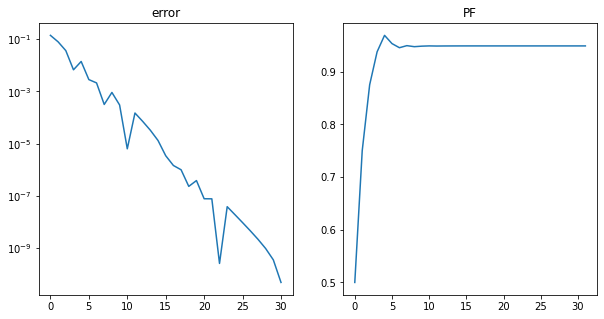

In [29]:
V_4_0 = V[3] # original voltage in the 4th node
i=0
pf = [0.5]
pf_low = 0.
pf_high = 1.
tol_d = 1e-10
dist_i = [(np.abs(V[3]) - np.abs(V1[3]))[0]]
dists=[]

while np.abs(dist_i)>tol_d:
    P_inv = from_pf_to_p(Smag0,pf[i]);
    Q_inv = from_pf_to_q(Smag0,pf[i]);
    Ppv =  np.asanyarray([0, 0, 0, P_inv, 0 ]).reshape(-1,1).astype(float)
    Qpv =  -np.asanyarray([0, 0, 0, Q_inv, 0 ]).reshape(-1,1).astype(float)
    Pi = P+Ppv
    Qi = Q+Qpv
    Vi, _,_,_,_,_,_, _= solve_lf(incidence,YN,VM,VA,VNM,VNA,KNM,KNA,Pi,Qi,PC,QC)
    dist_i = np.abs(Vi[3]) - np.abs(V_4_0)
    if dist_i>0:
        pf_new = (pf[i]+pf_low)/2;
        pf_high = pf[i];
    else:
        pf_new = (pf[i]+pf_high)/2;
        pf_low = pf[i];
    pf.append(pf_new)
    dists.append(dist_i)
    print('Iteration {}, dist {:0.3e}, v_4_mag {:0.3f}, pf {:0.3f}'.format(i, dist_i[0], np.abs(Vi[3])[0], pf[i]))
    i+= 1

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.abs(dists));
ax[0].set_title('error')
ax[0].semilogy()
ax[1].plot(pf)
ax[1].set_title('PF')
